## 导入库

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import  train_test_split
from sklearn.metrics import  mean_squared_error,mean_absolute_error
from plot import *
from process_read import *
from calculate import *
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna
from optuna.samplers import TPESampler
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os
import joblib


## 读取数据

### 读取站点预测数据

In [4]:

# 读取科大站点实测数据
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

file_path = r'E:/USTC_SP_Power/actual_value/安徽.永瑞光伏气象数据预测值.txt'

# 读取数据（假设数据分隔符为空格）
df = pd.read_csv(
    file_path,
    header=0,
    low_memory=False,
    names=['IssueTime','time','WindSpeed','WindDirection','temperature','Humidity','AirPressure',
           'TotalRadiation','DirectRadiation','DiffuseRadiation','ss']  # 直接指定列名
)

df["WindDirection"] = pd.to_numeric(df["WindDirection"], errors="coerce")  # 将非数值转为NaN
df["WindSpeed"] = pd.to_numeric(df["WindSpeed"], errors="coerce")
df["temperature"] = pd.to_numeric(df["temperature"], errors="coerce")  
df["Humidity"] = pd.to_numeric(df["Humidity"], errors="coerce")  
df["AirPressure"] = pd.to_numeric(df["AirPressure"], errors="coerce")  
df["TotalRadiation"] = pd.to_numeric(df["TotalRadiation"], errors="coerce")  
df["DirectRadiation"] = pd.to_numeric(df["DirectRadiation"], errors="coerce")  
df['time'] = pd.to_datetime((df['time']), errors='coerce')
df['ss'] = pd.to_numeric((df['ss']), errors='coerce')
df.drop_duplicates(subset='time', inplace=True)

df_act = df.copy()
df_act.drop(columns='IssueTime',inplace=True)
df_act.drop(columns='ss',inplace=True)
df_act


,time,WindSpeed,WindDirection,temperature,Humidity,AirPressure,TotalRadiation,DirectRadiation,DiffuseRadiation
0,2023-09-02 00:15:00,2.14,89.65,21.71,91.95,1009.22,0.0,0.0,0.0
1,2023-09-02 00:30:00,2.15,102.51,21.54,92.31,1009.17,0.0,0.0,0.0
2,2023-09-02 00:45:00,2.16,115.05,21.38,92.66,1009.12,0.0,0.0,0.0
3,2023-09-02 01:00:00,2.17,125.64,21.23,93.00,1009.07,0.0,0.0,0.0
4,2023-09-02 01:15:00,2.18,133.61,21.09,93.31,1009.02,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
118939,2024-11-01 23:00:00,2.18,352.49,13.85,81.34,300.00,0.0,0.0,0.0
118940,2024-11-01 23:15:00,2.19,352.71,13.73,81.97,300.00,0.0,0.0,0.0
118941,2024-11-01 23:30:00,2.19,353.32,13.59,82.63,300.00,0.0,0.0,0.0
118942,2024-11-01 23:45:00,2.21,354.24,13.46,83.30,300.00,0.0,0.0,0.0


### 读取iAMAS预测数据

In [9]:
result = collect_filename(r'E:\USTC_New_Past\USTC_Now_Predict','SP32_33.93N-116.69E_')

file_paths = result
print(file_paths)

dfs = [pd.read_csv(file, header=0,names=['time','predicted_radiation','predicted_direction','predicted_speed','predicted_temperature','predicted_humidity',
        'predicted_pressure']) for file in file_paths]

# 初始化一个空的 DataFrame 来存储第1天的数据
first_day_data = pd.DataFrame()

# 遍历每个 DataFrame 并筛选第1天的数据
for df in dfs:
    # 将 'time' 列转换为 datetime 类型
    df['time'] = pd.to_datetime(df['time'])

    # 找到最小的时间点作为第一天的开始
    min_time = df['time'].min()

    first_day_start = min_time
    first_day_end  = first_day_start + timedelta(days=1)

    first_day_df =  df[(df['time'] >= first_day_start) & (df['time'] < first_day_end)]
    first_day_data = pd.concat([first_day_data, first_day_df], ignore_index=True)

# first_day_data["value_now"] = pd.to_numeric(first_day_data["value_now"], errors="coerce")  # 将非数值转为NaN
first_day_data['time'] = pd.to_datetime((first_day_data['time']), errors='coerce')


['E:\\USTC_New_Past\\USTC_Now_Predict\\20230901\\SP32_33.93N-116.69E_2023-09-02to2023-09-04.txt', 'E:\\USTC_New_Past\\USTC_Now_Predict\\20230902\\SP32_33.93N-116.69E_2023-09-03to2023-09-05.txt', 'E:\\USTC_New_Past\\USTC_Now_Predict\\20230903\\SP32_33.93N-116.69E_2023-09-04to2023-09-06.txt', 'E:\\USTC_New_Past\\USTC_Now_Predict\\20230904\\SP32_33.93N-116.69E_2023-09-05to2023-09-07.txt', 'E:\\USTC_New_Past\\USTC_Now_Predict\\20230905\\SP32_33.93N-116.69E_2023-09-06to2023-09-08.txt', 'E:\\USTC_New_Past\\USTC_Now_Predict\\20230906\\SP32_33.93N-116.69E_2023-09-07to2023-09-09.txt', 'E:\\USTC_New_Past\\USTC_Now_Predict\\20230907\\SP32_33.93N-116.69E_2023-09-08to2023-09-10.txt', 'E:\\USTC_New_Past\\USTC_Now_Predict\\20230908\\SP32_33.93N-116.69E_2023-09-09to2023-09-11.txt', 'E:\\USTC_New_Past\\USTC_Now_Predict\\20230909\\SP32_33.93N-116.69E_2023-09-10to2023-09-12.txt', 'E:\\USTC_New_Past\\USTC_Now_Predict\\20230910\\SP32_33.93N-116.69E_2023-09-11to2023-09-13.txt', 'E:\\USTC_New_Past\\USTC_Now_

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
# from pygments.lexer import default

# 读取科大站点实测数据
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

file_path = r'E:/USTC_SP_Power/actual_value/安徽.永瑞光伏发电功率实测值.txt'

# 读取数据（假设数据分隔符为空格）
df = pd.read_csv(
    file_path,
    header=0,
    low_memory=False,
    names=["time", "power"]  # 直接指定列名
)
df['time'] = pd.to_datetime((df['time']), errors='coerce')
df.set_index('time', inplace=True)

#按15分钟重采样
mask = (df.index.minute%15 ==0) & (df.index.second == 0)
df = df.loc[mask]

df


,power
time,
2023-09-01 00:00:00,0.0
2023-09-01 00:15:00,0.0
2023-09-01 00:30:00,0.0
2023-09-01 00:45:00,0.0
2023-09-01 01:00:00,0.0
...,...
2024-11-01 23:00:00,0.0
2024-11-01 23:15:00,0.0
2024-11-01 23:30:00,0.0


In [11]:
# 将数据与first_daydata进行合并
# merged_df = df_act.merge(df, on='time', how='inner')
# 合并数据并去除列名中的括号
merged_df = df.merge(first_day_data, on='time', how='inner')

In [12]:
# 选择特征列
features = ['predicted_radiation','predicted_direction','predicted_speed','predicted_temperature','predicted_humidity',
           'predicted_pressure']
target = ['power']
X = merged_df[features]
y = merged_df[target]

## 划分训练集和测试集

In [13]:
# 每个月前24天的数据作为训练集，后面的数据作为测试集
train_mask = merged_df['time'].dt.day <= 24

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[~train_mask] 
y_test = y[~train_mask] 

In [14]:
X_train.columns


Index(['predicted_radiation', 'predicted_direction', 'predicted_speed',
       'predicted_temperature', 'predicted_humidity', 'predicted_pressure'],
      dtype='object')

In [15]:
y_train.columns

Index(['power'], dtype='object')

## 参数调优 贝叶斯优化

In [ ]:
# 确保在此之前已经定义了 X_train 和 y_train 变量

# 定义目标函数
def objective(trial):
        # 定义要调优的超参数空间
        param = {
                'objective': 'regression',
                'metric': 'rmse',
                'boosting_type': 'gbdt',
                'random_state': 42,
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),  # LightGBM 中的列采样参数
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
                'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        }

        # 创建LightGBM模型
        model = lgb.LGBMRegressor(**param)

        # 交叉验证
        from sklearn.model_selection import cross_val_score
        import numpy as np
        try:
            
            rmse = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
            print("使用 neg_root_mean_squared_error，RMSE：", rmse)
        except ValueError:
           
            mse = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
            rmse = np.sqrt(mse)
            print("使用 neg_mean_squared_error，RMSE：", rmse)

        return rmse  # 返回正的 RMSE 值

# 创建Optuna的研究对象
# study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
# # study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=50))
# study.optimize(objective, n_trials=100)

# # 输出最佳参数和最佳得分
# print("贝叶斯优化找到的最佳参数：")
# 尝试不同的随机种子
for seed in [42, 123, 456, 789, 1024]:
    study = optuna.create_study(direction='minimize', 
                               sampler=TPESampler(seed=seed))
    study.optimize(objective, n_trials=100)
    print(f"种子 {seed} 的最佳参数:", study.best_params)
for key, value in study.best_params.items():
        print(f"    {key}: {value}")
print("贝叶斯优化最佳得分（RMSE）：", study.best_value)


In [16]:
import json
# 保存最优参数
best_params = study.best_params
# 将最优参数保存为json文件
with open('best_params_6.json', 'w', encoding='utf-8') as f:
    json.dump(best_params, f, ensure_ascii=False, indent=4)
print("最优参数已保存到best_params_6.json文件中")


NameError: name 'study' is not defined

## 使用最佳参数训练模型

In [41]:
# 使用最佳参数训练模型
best_params = {
    "n_estimators": 78,
    "max_depth": 5,
    "learning_rate": 0.04263822198280162,
    "subsample": 0.8822621793992009,
    "feature_fraction": 0.8710509462500188,
    "reg_alpha": 0.6779016408714649,
    "reg_lambda": 0.4011092303350372,
    "min_child_samples": 11,
    "num_leaves": 64
}
best_params['objective'] = 'regression'
best_params['random_state'] = 42
model = lgb.LGBMRegressor(**best_params)
model.fit(X_train, y_train)

os.makedirs(r'e:\Power_Pre_Model\models', exist_ok=True)
joblib.dump(model, fr'e:\Power_Pre_Model\models\lightgbm4.pkl')
print(f"模型已保存为 lightgbm4.pkl")


[LightGBM] [Warning] feature_fraction is set=0.8710509462500188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8710509462500188
[LightGBM] [Warning] feature_fraction is set=0.8710509462500188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8710509462500188
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 32026, number of used features: 6
[LightGBM] [Info] Start training from score 14.157725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

### 评估模型

In [42]:
# 在测试集上评估模型
y_pred = model.predict(X_test)

# 计算多种评估指标
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np
import pandas as pd
# 计算所有评估指标
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

# 计算归一化指标
y_mean = np.mean(np.abs(y_test))
nmae = mae / y_mean
nmae_percentage = nmae * 100

y_range = np.max(y_test) - np.min(y_test)
nrmse_range = rmse / y_range
nrmse_mean = rmse / np.mean(y_test)
nrmse_percentage = nrmse_mean * 100

# 创建评估指标字典
metrics_dict = {
    '评估指标': [
        'MSE (均方误差)',
        'RMSE (根均方误差)',
        'MAE (平均绝对误差)',
        'R² (决定系数)',
        '解释方差分数',
        'NMAE (归一化平均绝对误差)',
        'NMAE百分比',
        'NRMSE (按范围归一化)',
        'NRMSE (按平均值归一化)',
        'NRMSE百分比'
    ],
    '数值': [
        mse,
        rmse,
        mae,
        r2,
        evs,
        nmae,
        nmae_percentage,
        nrmse_range,
        nrmse_mean,
        nrmse_percentage
    ]
}

# 创建DataFrame并保存为CSV
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.to_csv('model_evaluation_metrics.csv', index=False, encoding='utf-8-sig')

# 打印评估指标
print("测试集均方误差（MSE）：", mse)
print("测试集根均方误差（RMSE）：", rmse)
print("测试集平均绝对误差（MAE）：", mae)
print("测试集决定系数（R²）：", r2)
print("测试集解释方差分数：", evs)
print("测试集归一化平均绝对误差（NMAE）：", nmae)
print("测试集归一化平均绝对误差百分比：", nmae_percentage, "%")
print("测试集归一化均方根误差（NRMSE，按范围）：", nrmse_range)
print("测试集归一化均方根误差（NRMSE，按平均值）：", nrmse_mean)
print("测试集归一化均方根误差百分比：", nrmse_percentage, "%")



[LightGBM] [Warning] feature_fraction is set=0.8710509462500188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8710509462500188
测试集均方误差（MSE）： 138.39362061918277
测试集根均方误差（RMSE）： 11.76408180093894
测试集平均绝对误差（MAE）： 6.576076538048224
测试集决定系数（R²）： 0.7351004471446252
测试集解释方差分数： 0.7370914214492255
测试集归一化平均绝对误差（NMAE）： 0.44675210146022654
测试集归一化平均绝对误差百分比： 44.67521014602266 %
测试集归一化均方根误差（NRMSE，按范围）： 0.13335602698723317
测试集归一化均方根误差（NRMSE，按平均值）： 0.7992042422120812
测试集归一化均方根误差百分比： 79.92042422120812 %


### 特征重要性可视化

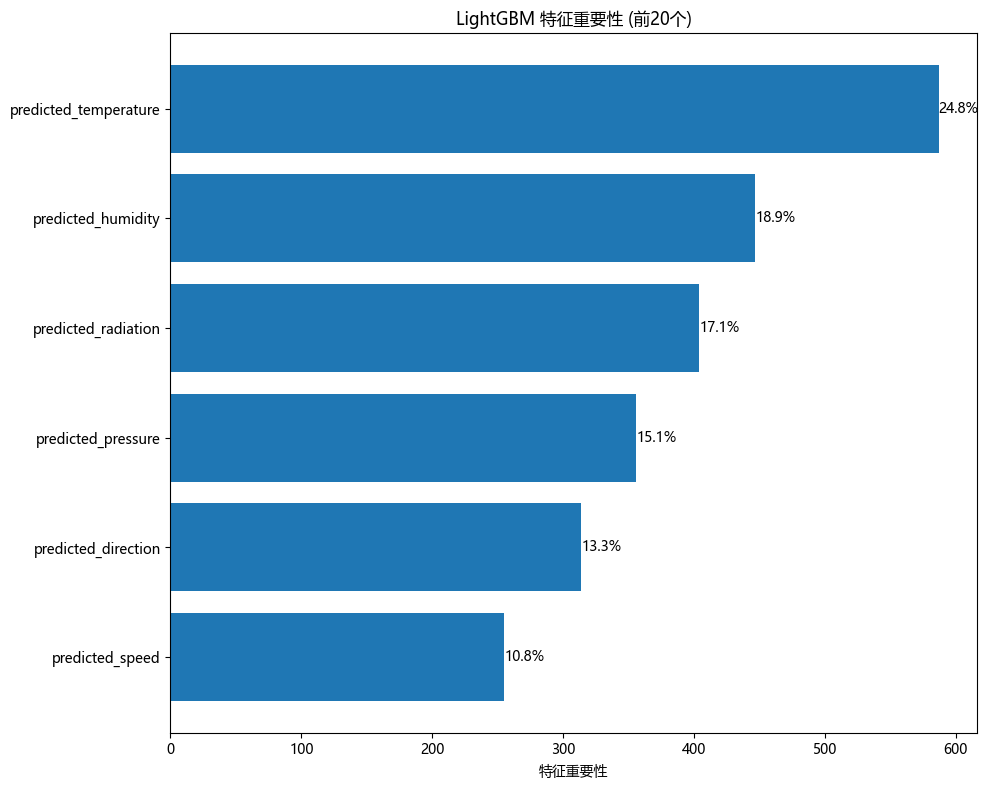

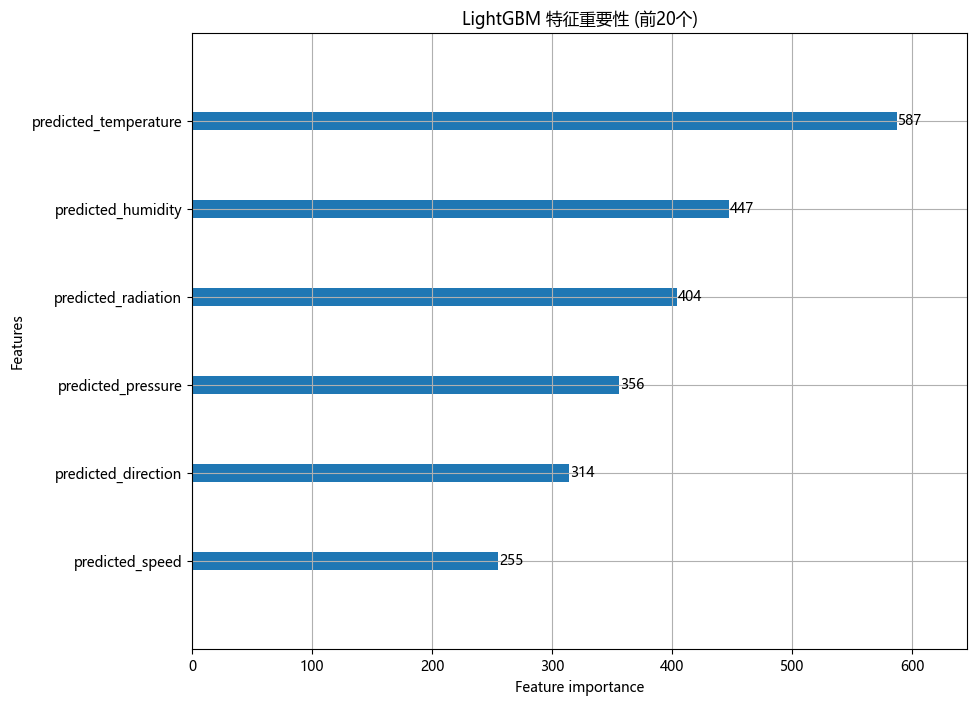

In [19]:
best_model = model
import matplotlib.pyplot as plt
import numpy as np

# 获取特征重要性
importance = best_model.feature_importances_

# 获取特征名称
feature_names = best_model.feature_name_

# 创建特征重要性字典
importance_dict = {name: score for name, score in zip(feature_names, importance)}

# 将特征重要性转换为百分比
total_importance = sum(importance_dict.values())
importance_percent = {k: (v / total_importance) * 100 for k, v in importance_dict.items()}

# 按重要性排序
sorted_idx = np.argsort(importance)
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importance = importance[sorted_idx]

# 绘制特征重要性图
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_features[-20:])), sorted_importance[-20:])
plt.yticks(range(len(sorted_features[-20:])), sorted_features[-20:])
plt.xlabel('特征重要性')
plt.title('LightGBM 特征重要性 (前20个)')

# 添加百分比标签
for i, v in enumerate(sorted_importance[-20:]):
    percent = (v / total_importance) * 100
    plt.text(v, i, f"{percent:.1f}%", va='center')

plt.tight_layout()
plt.show()

# 另一种可视化方式：使用lgb内置的plot_importance
lgb.plot_importance(best_model, max_num_features=20, figsize=(10, 8))
plt.title('LightGBM 特征重要性 (前20个)')
plt.show()

### lightGBM预测效果

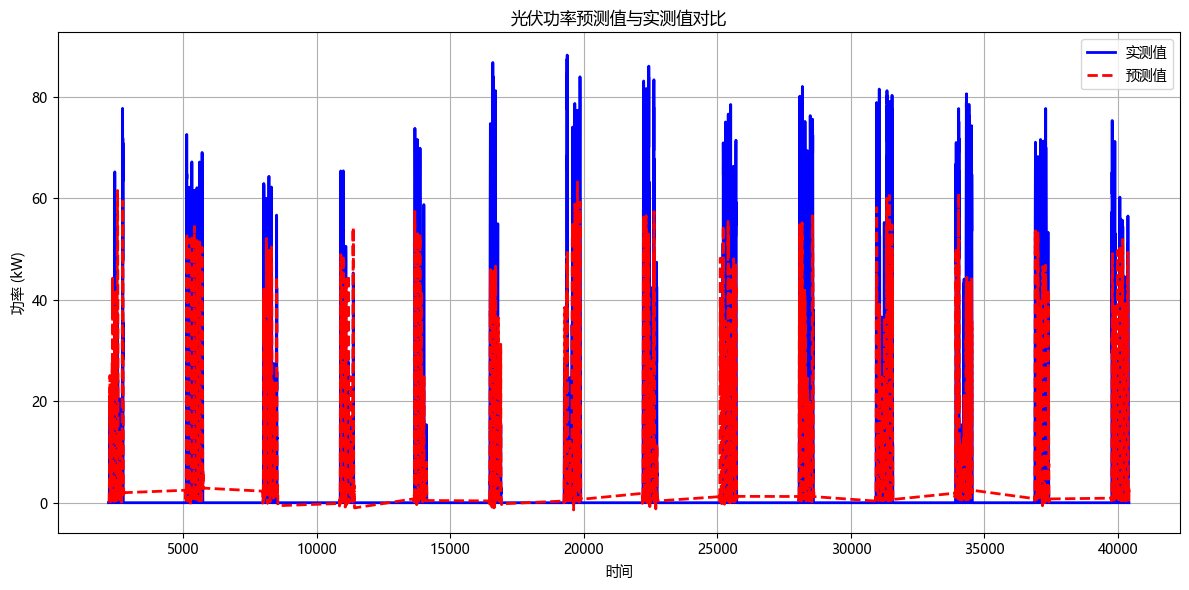

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# 假设 y_test 是实测值，y_pred 是预测值，X_test 包含时间列
# 如果 X_test 中没有时间列，需要从原始数据中提取

# 创建时间序列图
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, 'b-', label='实测值', linewidth=2)
plt.plot(X_test.index, y_pred, 'r--', label='预测值', linewidth=2)
plt.xlabel('时间')
plt.ylabel('功率 (kW)')
plt.title('光伏功率预测值与实测值对比')
plt.legend()
plt.grid(True)

# 如果 X_test.index 是日期时间类型，优化 x 轴显示
if isinstance(X_test.index, pd.DatetimeIndex):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gcf().autofmt_xdate()  # 自动旋转日期标签

plt.tight_layout()
plt.show()

# 保存图片
plt.savefig('power_prediction_comparison.png', dpi=300, bbox_inches='tight')

## LSTM建模

### LSTM划分数据集和测试集

In [21]:
features_lstm = ['predicted_radiation','predicted_direction','predicted_speed','predicted_temperature','predicted_humidity',
           'predicted_pressure']
target_lstm = ['power']

X_lstm = merged_df[features_lstm]
y_lstm = merged_df[target_lstm]

train_mask = merged_df['time'].dt.day <= 24

X_train_lstm = X_lstm[train_mask]
y_train_lstm = y[train_mask]
X_test_lstm = X_lstm[~train_mask] 
y_test_lstm = y_lstm[~train_mask] 


### 数据准备

In [22]:
# 数据标准化
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train_lstm)
y_train_scaled = scaler_y.fit_transform(y_train_lstm.values.reshape(-1, 1))
X_test_scaled = scaler_X.transform(X_test_lstm)
y_test_scaled = scaler_y.transform(y_test_lstm.values.reshape(-1, 1))

# 保存标准化器，用于后续预测时的逆变换
os.makedirs(r'e:\Power_Pre_Model\models_scaler', exist_ok=True)
joblib.dump(scaler_X, r'e:\Power_Pre_Model\models\scaler_X.pkl')
joblib.dump(scaler_y, r'e:\Power_Pre_Model\models\scaler_y.pkl')

# 创建时间序列数据
def create_sequences(X, y, time_steps=24):
    """
    创建时间序列数据
    X: 特征数据
    y: 目标变量
    time_steps: 时间窗口大小
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 设置时间步长
time_steps = 48

# 创建序列数据
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

print(f"训练数据形状: {X_train_seq.shape}, {y_train_seq.shape}")
print(f"测试数据形状: {X_test_seq.shape}, {y_test_seq.shape}")

训练数据形状: (31978, 48, 6), (31978, 1)
测试数据形状: (8436, 48, 6), (8436, 1)


### 构建LSTM模型

In [23]:
# 构建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 打印模型结构
model.summary()

e:\Power_Pre_Model\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 48, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

## 训练LSTM模型

In [24]:
# 训练模型
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 设置早停和模型检查点
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath=r'e:\Power_Pre_Model\models\lstm_model.h5',
    monitor='val_loss',
    save_best_only=True
)

# 训练模型
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# 保存模型
model.save(r'e:\Power_Pre_Model\models\lstm_final_model.h5')
print("LSTM模型已保存")

Epoch 1/100
799/800 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0297

800/800 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0296 - val_loss: 0.0194
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0209

800/800 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0209 - val_loss: 0.0175
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0194

800/800 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0194 - val_loss: 0.0174
Epoch 4/100
798/800 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0166

800/800 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0166 - val_loss: 0.0173
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0165 - val_loss: 0.0235
Epoch 6/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0155 - val_loss: 0.0174
Epoch 7/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0156 - val_loss: 0.0197
Epoch 8/100
799/800 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0142

800/800 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.0142 - val_loss: 0.0171
Epoch 9/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0132 - val_loss: 0.0200
Epoch 10/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0131 - val_loss: 0.0186
Epoch 11/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0128 - val_loss: 0.0185
Epoch 12/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0122 - val_loss: 0.0185
Epoch 13/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0116 - val_loss: 0.0209
Epoch 14/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0101 - val_loss: 0.0268
Epoch 15/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0105 - val_loss: 0.0207
Epoch 16/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0102 - val_loss: 0.0217
Epoch 17/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0101 - val_loss: 0.0197
Epoch 18/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0093 - val_loss: 0.0224


LSTM模型已保存


## 评估模型

In [33]:
# 评估模型
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 预测
y_pred_scaled = model.predict(X_test_seq)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

# 计算评估指标
mse = mean_squared_error(y_test_actual, y_pred_lstm)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_lstm)
r2 = r2_score(y_test_actual, y_pred_lstm)

print("测试集均方误差（MSE）：", mse)
print("测试集根均方误差（RMSE）：", rmse)
print("测试集平均绝对误差（MAE）：", mae)
print("测试集决定系数（R²）：", r2)

# 计算归一化指标
y_mean = np.mean(np.abs(y_test_actual))
nmae = mae / y_mean
nmae_percentage = nmae * 100

y_range = np.max(y_test_actual) - np.min(y_test_actual)
nrmse_range = rmse / y_range
nrmse_mean = rmse / np.mean(y_test_actual)
nrmse_percentage = nrmse_mean * 100

print("测试集归一化平均绝对误差（NMAE）：", nmae)
print("测试集归一化平均绝对误差百分比：", nmae_percentage, "%")
print("测试集归一化均方根误差（NRMSE，按范围）：", nrmse_range)
print("测试集归一化均方根误差（NRMSE，按平均值）：", nrmse_mean)
print("测试集归一化均方根误差百分比：", nrmse_percentage, "%")

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
测试集均方误差（MSE）： 130.32607046623215
测试集根均方误差（RMSE）： 11.41604443168614
测试集平均绝对误差（MAE）： 6.587210183993563
测试集决定系数（R²）： 0.7515316835076686
测试集归一化平均绝对误差（NMAE）： 0.4454571399345724
测试集归一化平均绝对误差百分比： 44.54571399345724 %
测试集归一化均方根误差（NRMSE，按范围）： 0.129410722832434
测试集归一化均方根误差（NRMSE，按平均值）： 0.7720048943120044
测试集归一化均方根误差百分比： 77.20048943120044 %


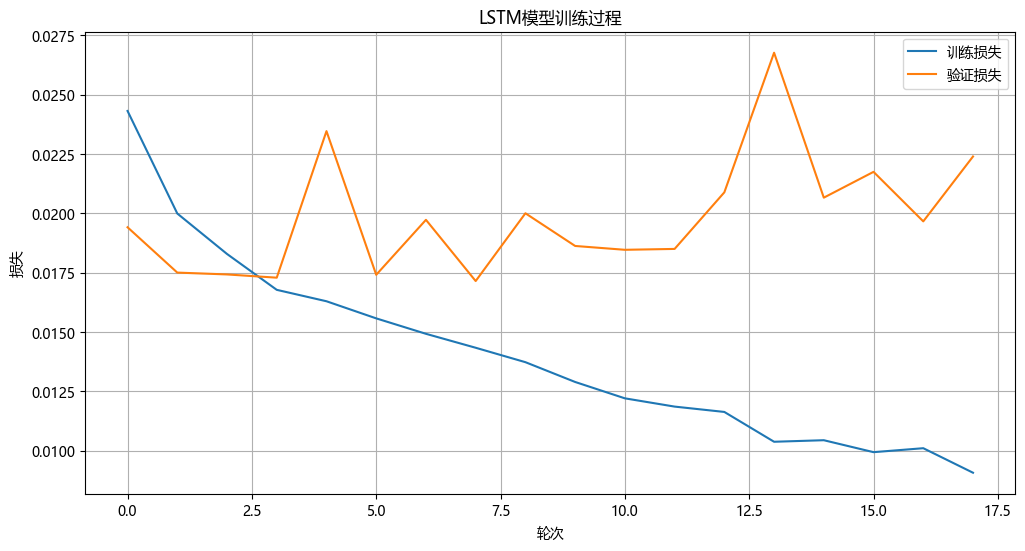

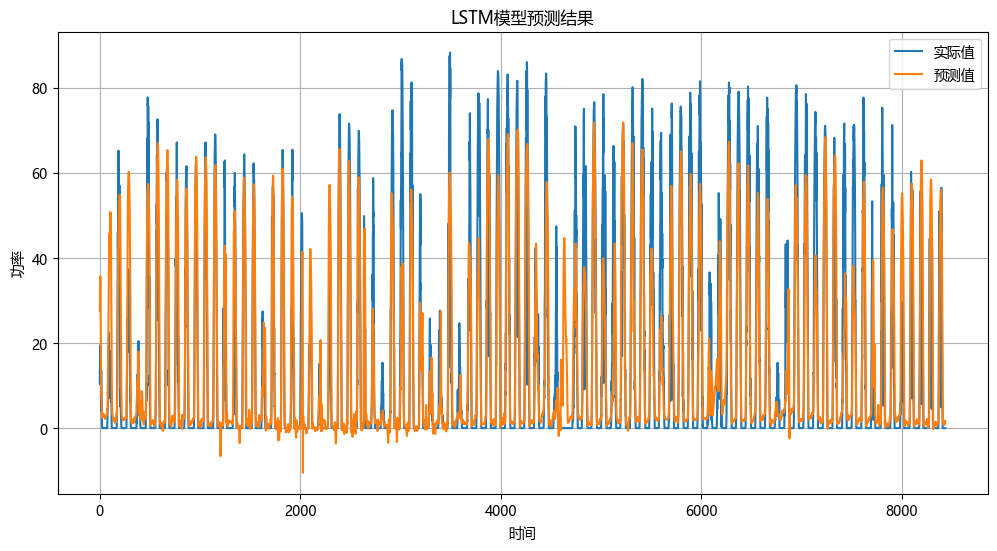

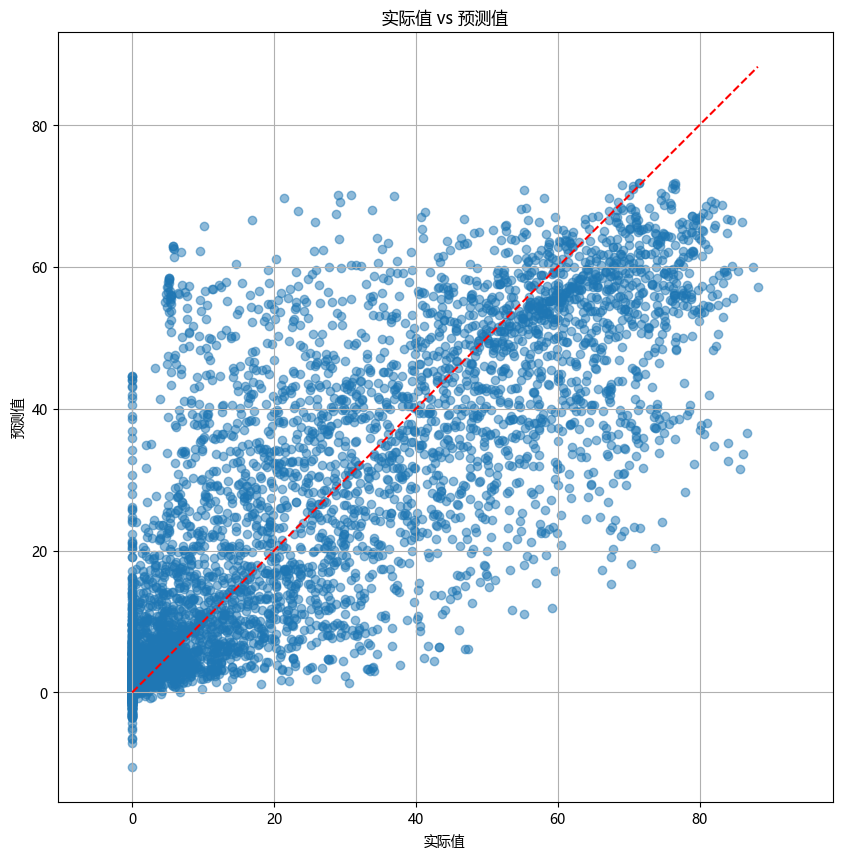

In [34]:
# 可视化训练过程
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.title('LSTM模型训练过程')
plt.xlabel('轮次')
plt.ylabel('损失')
plt.legend()
plt.grid(True)
plt.show()

# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='实际值')
plt.plot(y_pred_lstm, label='预测值')
plt.title('LSTM模型预测结果')
plt.xlabel('时间')
plt.ylabel('功率')
plt.legend()
plt.grid(True)
plt.show()

# 绘制散点图
plt.figure(figsize=(10, 10))
plt.scatter(y_test_actual, y_pred_lstm, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel('实际值')
plt.ylabel('预测值')
plt.title('实际值 vs 预测值')
plt.axis('equal')
plt.grid(True)
plt.show()

## 集成LightGBM和LSTM模型

In [35]:
# 加载LightGBM模型
lgb_model = joblib.load(r'e:\Power_Pre_Model\models\lightgbm4.pkl')

# 使用LightGBM模型进行预测
lgb_pred = lgb_model.predict(X_test)

# 将LSTM预测结果转换为一维数组
lstm_pred = y_pred_lstm.flatten()
print(lgb_pred.shape)
print(lstm_pred.shape)
# 确保两个预测结果长度一致（可能需要调整）
min_len = min(len(lgb_pred), len(lstm_pred))
lgb_pred = lgb_pred[:min_len]
lstm_pred = lstm_pred[:min_len]
y_test_ensemble = y_test_actual[:min_len]

# 简单平均集成
# ensemble_pred = (lgb_pred + lstm_pred) / 2

# 加权平均集成（可以调整权重）
ensemble_pred = lgb_pred

# 评估集成模型
ensemble_mse = mean_squared_error(y_test_ensemble, ensemble_pred)
ensemble_rmse = np.sqrt(ensemble_mse)
ensemble_mae = mean_absolute_error(y_test_ensemble, ensemble_pred)
ensemble_r2 = r2_score(y_test_ensemble, ensemble_pred)

print("集成模型测试集均方误差（MSE）：", ensemble_mse)
print("集成模型测试集根均方误差（RMSE）：", ensemble_rmse)
print("集成模型测试集平均绝对误差（MAE）：", ensemble_mae)
print("集成模型测试集决定系数（R²）：", ensemble_r2)

# 计算归一化指标
ensemble_nmae = ensemble_mae / y_mean
ensemble_nrmse_range = ensemble_rmse / y_range
ensemble_nrmse_mean = ensemble_rmse / np.mean(y_test_ensemble)

print("集成模型测试集归一化平均绝对误差（NMAE）：", ensemble_nmae)
print("集成模型测试集归一化均方根误差（NRMSE，按范围）：", ensemble_nrmse_range)
print("集成模型测试集归一化均方根误差（NRMSE，按平均值）：", ensemble_nrmse_mean)

[LightGBM] [Warning] feature_fraction is set=0.8710509462500188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8710509462500188
(8484,)
(8436,)
集成模型测试集均方误差（MSE）： 1200.6223644639617
集成模型测试集根均方误差（RMSE）： 34.64999804421296
集成模型测试集平均绝对误差（MAE）： 27.24930707233954
集成模型测试集决定系数（R²）： -1.2890018595220165
集成模型测试集归一化平均绝对误差（NMAE）： 1.8427221926421455
集成模型测试集归一化均方根误差（NRMSE，按范围）： 0.3927876524900427
集成模型测试集归一化均方根误差（NRMSE，按平均值）： 2.343190606703239
